In [11]:
import numpy as np
import os

import tensorflow as tf

In [2]:
import warnings
warnings.filterwarnings('ignore')

#### to make this notebook's output stable across runs

In [12]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

### To plot pretty figures

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

### A couple utility functions to plot grayscale and RGB images

In [4]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")

## Convolutional layer

In [5]:
from sklearn.datasets import load_sample_image

china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")

/home/saucecat/anaconda2/lib/python2.7/site-packages/sklearn/datasets/base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]
/home/saucecat/anaconda2/lib/python2.7/site-packages/sklearn/datasets/base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]
/home/saucecat/anaconda2/lib/python2.7/site-packages/sklearn/datasets/base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]
/home/saucecat/anaconda2/lib/python2.7/site-packages/sklearn/datasets/base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecate

#### each image is actually a numpy matrix

In [8]:
print type(china)
print china.shape

<type 'numpy.ndarray'>
(427, 640, 3)


#### we can simply crop image by slicing the numpy matrix

In [9]:
image = china[150:220, 130:250]
height, width, channels = image.shape

#### turn a color image into grayscale

In [10]:
image_grayscale = image.mean(axis=2).astype(np.float32)

# batch_size, height, width, channel
images = image_grayscale.reshape(1, height, width, 1)

#### show the original image

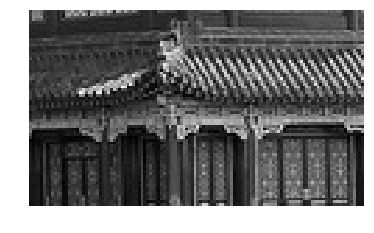

In [14]:
plot_image(images[0, :, :, 0])
plt.show()

### create 2 simple filters (7, 7, 1)

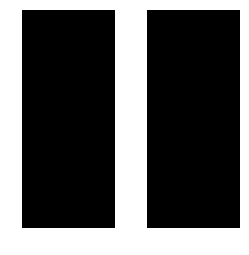

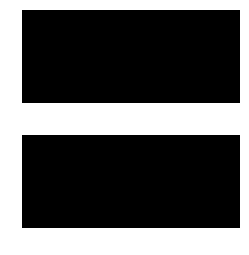

In [15]:
fmap = np.zeros(shape=(7, 7, 1, 2), dtype=np.float32)
fmap[:, 3, 0, 0] = 1
fmap[3, :, 0, 1] = 1
plot_image(fmap[:, :, 0, 0])
plt.show()
plot_image(fmap[:, :, 0, 1])
plt.show()

### apply these 2 simple filters on original image

In [16]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, height, width, 1))
feature_maps = tf.constant(fmap)
convolution = tf.nn.conv2d(X, feature_maps, strides=[1, 1, 1, 1], padding="SAME")

In [17]:
with tf.Session() as sess:
    output = convolution.eval(feed_dict={X: images})

#### show convolution results
The results would have 2 channels because there are 2 filters

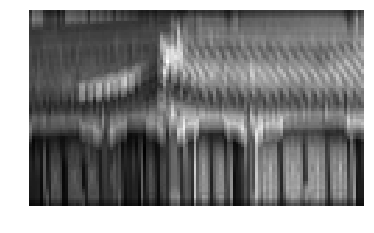

In [18]:
plot_image(output[0, :, :, 0])
plt.show()

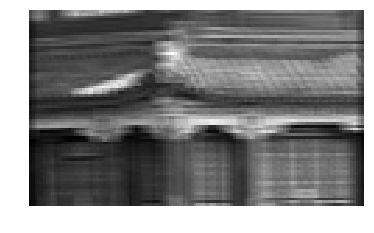

In [19]:
plot_image(output[0, :, :, 1])
plt.show()

### for real usecase, we will use tf.layers.conv2d()
We don't manually design the filters, but let the neural nets to update and adjust

In [21]:
dataset = np.array([china, flower], dtype=np.float32)
batch_size, height, width, channels = dataset.shape

In [22]:
reset_graph()

X = tf.placeholder(dtype=tf.float32, shape=(None, height, width, channels))
conv = tf.layers.conv2d(X, filters=2, kernel_size=7, strides=[2, 2], padding="SAME")

In [23]:
# initialize the filters
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    output = sess.run(conv, feed_dict={X: dataset})

In [24]:
print output.shape

(2, 214, 320, 2)


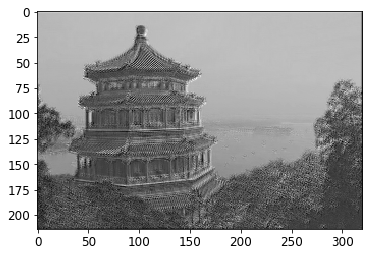

In [25]:
# plot 1st image's 2nd feature map
plt.imshow(output[0, :, :, 1], cmap="gray")
plt.show()

## VALID vs SAME padding

In [26]:
reset_graph()

filter_primes = np.array([2., 3., 5., 7., 11., 13.], dtype=np.float32)
x = tf.constant(np.arange(1, 13+1, dtype=np.float32).reshape([1, 1, 13, 1]))
filters = tf.constant(filter_primes.reshape(1, 6, 1, 1))

valid_conv = tf.nn.conv2d(x, filters, strides=[1, 1, 5, 1], padding='VALID')
same_conv = tf.nn.conv2d(x, filters, strides=[1, 1, 5, 1], padding='SAME')

with tf.Session() as sess:
    print("VALID:\n", valid_conv.eval())
    print("SAME:\n", same_conv.eval())

('VALID:\n', array([[[[ 184.],
         [ 389.]]]], dtype=float32))
('SAME:\n', array([[[[ 143.],
         [ 348.],
         [ 204.]]]], dtype=float32))


In [28]:
print("VALID:")
print(np.array([1,2,3,4,5,6]).T.dot(filter_primes))
print(np.array([6,7,8,9,10,11]).T.dot(filter_primes))

# make sure all values are used
print("SAME:")
print(np.array([0,1,2,3,4,5]).T.dot(filter_primes))
print(np.array([5,6,7,8,9,10]).T.dot(filter_primes))
print(np.array([10,11,12,13,0,0]).T.dot(filter_primes))

VALID:
184.0
389.0
SAME:
143.0
348.0
204.0


## Pooling layer

In [30]:
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
max_pool = tf.nn.max_pool(X, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")

with tf.Session() as sess:
    output = sess.run(max_pool, feed_dict={X: dataset})

In [31]:
print dataset.shape
print output.shape

(2, 427, 640, 3)
(2, 213, 320, 3)


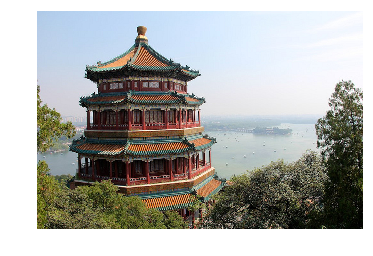

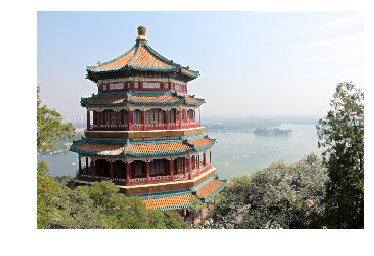

In [34]:
plot_color_image(dataset[0])
plt.show()
    
plot_color_image(output[0])
plt.show()